In [1]:
!pip install gurobipy
!pip install pyomo



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!grbgetkey YOUR_LICENSE_KEY


info  : grbgetkey version 12.0.0, build v12.0.0rc1
info  : Platform is win64 (windows) - Windows 11.0 (22631.2)
error : Key code invalid format


In [3]:
!gurobi_cl --version


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))
Copyright (c) 2024, Gurobi Optimization, LLC


## QUES-1

Read LP format model from file C:\Users\aggar\AppData\Local\Temp\tmpdtd1n4oe.pyomo.lp
Reading time = 0.00 seconds
x1: 131 rows, 120 columns, 510 nonzeros
Set parameter TimeLimit to value 30
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  30
MIPGap  0.01

Optimize a model with 131 rows, 120 columns and 510 nonzeros
Model fingerprint: 0xb354d198
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 879.0340380
Presolve removed 20 rows and 0 columns
Presolve time: 0.00s
Presolved: 111 rows, 120 columns, 986 nonzeros
Variable types: 10

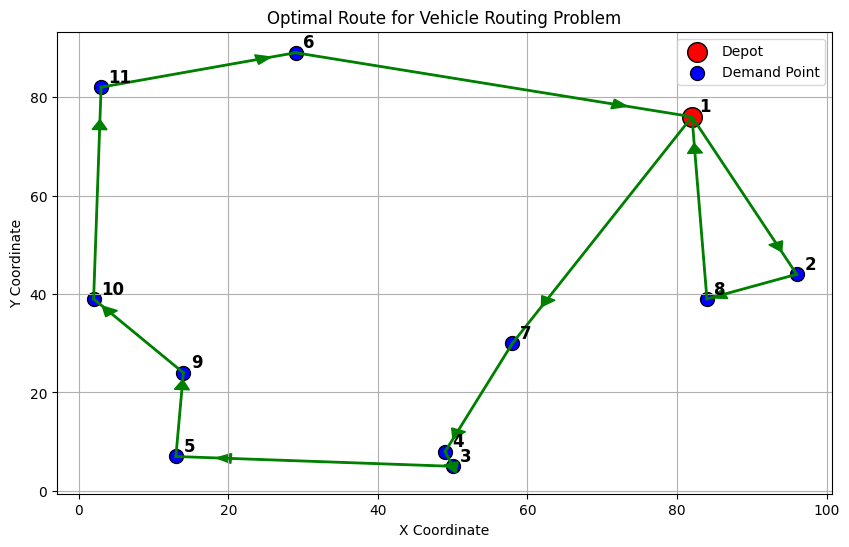

In [ ]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np


nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Node set
demand = {1: 0, 2: 19, 3: 21, 4: 6, 5: 19, 6: 7, 7: 12, 8: 16, 9: 6, 10: 16, 11: 8}  # Demand per node
capacity = 100  # Vehicle capacity

# Coordinates
coords = {
    1: (82, 76), 2: (96, 44), 3: (50, 5), 4: (49, 8), 5: (13, 7),
    6: (29, 89), 7: (58, 30), 8: (84, 39), 9: (14, 24), 10: (2, 39), 11: (3, 82)
}

#  Euclidean distances
def euclidean_distance(i, j):
    return np.sqrt((coords[i][0] - coords[j][0])**2 + (coords[i][1] - coords[j][1])**2)

distances = {(i, j): euclidean_distance(i, j) for i in nodes for j in nodes if i != j}

model = ConcreteModel()

# Decision variables
model.x = Var(nodes, nodes, domain=Binary)  
model.u = Var(nodes, within=NonNegativeReals)  

# Objective: Minimize total travel distance
model.obj = Objective(expr=sum(distances[i, j] * model.x[i, j] for i in nodes for j in nodes if i != j), sense=minimize)

# Constraints
model.visit_once = ConstraintList()
for i in nodes[1:]:  
    model.visit_once.add(sum(model.x[i, j] for j in nodes if i != j) == 1)
    model.visit_once.add(sum(model.x[j, i] for j in nodes if i != j) == 1)

# Depot balance: 
model.depot_balance = Constraint(expr=sum(model.x[1, j] for j in nodes if j != 1) == sum(model.x[j, 1] for j in nodes if j != 1))

# Subtour elimination 
model.subtour_elim = ConstraintList()
for i in nodes[1:]:
    for j in nodes[1:]:
        if i != j:
            model.subtour_elim.add(model.u[i] - model.u[j] + capacity * model.x[i, j] <= capacity - demand[j])

# Capacity constraints
model.capacity_constraints = ConstraintList()
for i in nodes[1:]:
    model.capacity_constraints.add(demand[i] <= model.u[i])
    model.capacity_constraints.add(model.u[i] <= capacity)


solver = SolverFactory('gurobi')
solver.options['TimeLimit'] = 30 
solver.options['MIPGap'] = 0.01 

result = solver.solve(model, tee=True)


routes = [(i, j) for i in nodes for j in nodes if i != j and model.x[i, j]() > 0.5]
total_distance = model.obj.expr()

print("\n✅ **Optimal Routes:**", routes)
print("🚀 **Total Distance:**", total_distance)


plt.figure(figsize=(10, 6))


for node, (x, y) in coords.items():
    if node == 1:
        plt.scatter(x, y, c='red', s=200, label='Depot', edgecolors='black')  # Depot
    else:
        plt.scatter(x, y, c='blue', s=100, label='Demand Point' if node == 2 else "", edgecolors='black')  # Demand points
    plt.text(x + 1, y + 1, str(node), fontsize=12, fontweight='bold')  # Label nodes


for (i, j) in routes:
    x_values = [coords[i][0], coords[j][0]]
    y_values = [coords[i][1], coords[j][1]]
    plt.plot(x_values, y_values, 'g-', linewidth=2)  # Draw paths
    plt.arrow(coords[i][0], coords[i][1], (coords[j][0] - coords[i][0]) * 0.8, (coords[j][1] - coords[i][1]) * 0.8,
              head_width=2, head_length=2, fc='green', ec='green')  # Direction arrows

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Optimal Route for Vehicle Routing Problem")
plt.legend()
plt.grid(True)
plt.show()


**Optimal Routes:** [(1, 2), (1, 7), (2, 8), (3, 5), (4, 3), (5, 9), (6, 1), (7, 4), (8, 1), (9, 10), (10, 11), (11, 6)]

**Total Distance:** 361.60028508789037

## QUES-2

Read LP format model from file C:\Users\aggar\AppData\Local\Temp\tmpuluy112c.pyomo.lp
Reading time = 0.02 seconds
x1: 131 rows, 120 columns, 510 nonzeros
Set parameter TimeLimit to value 30
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  30
MIPGap  0.01

Optimize a model with 131 rows, 120 columns and 510 nonzeros
Model fingerprint: 0xb354d198
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 879.0340380
Presolve removed 20 rows and 0 columns
Presolve time: 0.01s
Presolved: 111 rows, 120 columns, 986 nonzeros
Variable types: 10

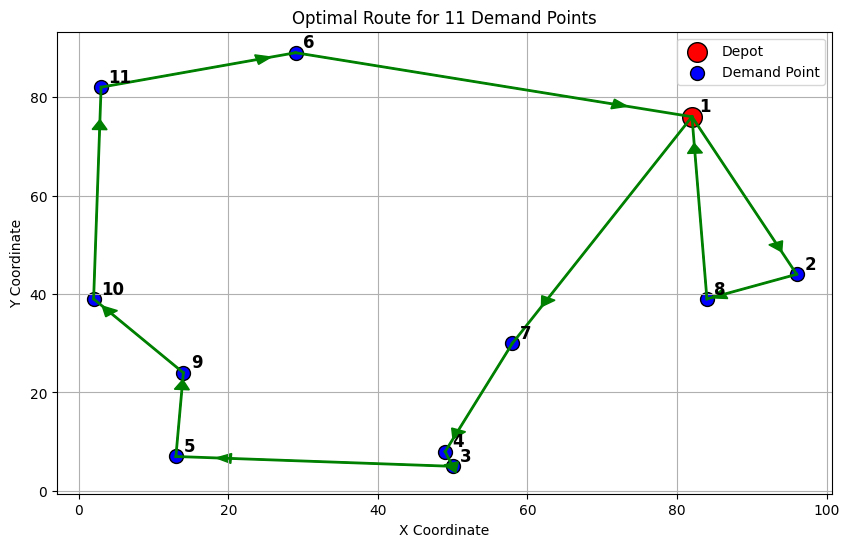

Read LP format model from file C:\Users\aggar\AppData\Local\Temp\tmpzsfbow4i.pyomo.lp
Reading time = 0.02 seconds
x1: 155 rows, 143 columns, 616 nonzeros
Set parameter TimeLimit to value 30
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  30
MIPGap  0.01

Optimize a model with 155 rows, 143 columns and 616 nonzeros
Model fingerprint: 0x9a41f612
Variable types: 11 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 838.7768180
Presolve removed 22 rows and 0 columns
Presolve time: 0.00s
Presolved: 133 rows, 143 columns, 1188 nonzeros
Variable types: 1

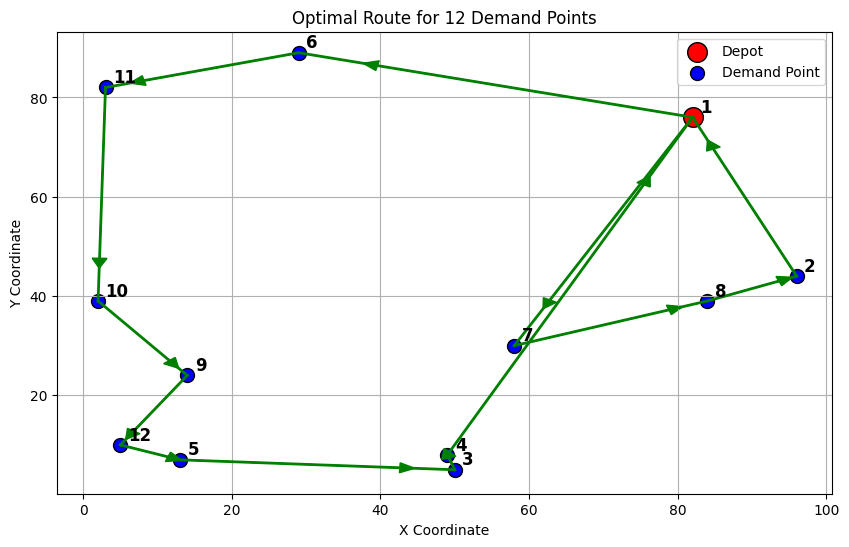

Read LP format model from file C:\Users\aggar\AppData\Local\Temp\tmpamkepz0f.pyomo.lp
Reading time = 0.02 seconds
x1: 181 rows, 168 columns, 732 nonzeros
Set parameter TimeLimit to value 30
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  30
MIPGap  0.01

Optimize a model with 181 rows, 168 columns and 732 nonzeros
Model fingerprint: 0x4154b7bb
Variable types: 12 continuous, 156 integer (156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 988.9254365
Presolve removed 24 rows and 0 columns
Presolve time: 0.00s
Presolved: 157 rows, 168 columns, 1418 nonzeros
Variable types: 1

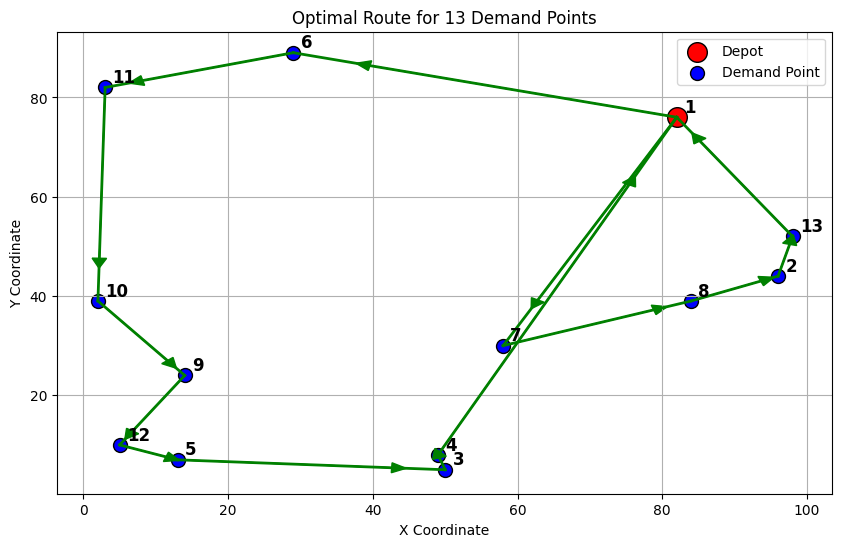

In [9]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np
import time


coords = {
    1: (82, 76), 2: (96, 44), 3: (50, 5), 4: (49, 8), 5: (13, 7),
    6: (29, 89), 7: (58, 30), 8: (84, 39), 9: (14, 24), 10: (2, 39),
    11: (3, 82), 12: (5, 10), 13: (98, 52)
}

demand = {1: 0, 2: 19, 3: 21, 4: 6, 5: 19, 6: 7, 7: 12, 8: 16, 9: 6, 10: 16, 11: 8, 12: 14, 13: 21}
capacity = 100  # Vehicle capacity


def euclidean_distance(i, j):
    return np.sqrt((coords[i][0] - coords[j][0])**2 + (coords[i][1] - coords[j][1])**2)


def solve_vrp(num_nodes):
    nodes = list(range(1, num_nodes + 1))  
    distances = {(i, j): euclidean_distance(i, j) for i in nodes for j in nodes if i != j}

   
    model = ConcreteModel()

    # Decision variables
    model.x = Var(nodes, nodes, domain=Binary) 
    model.u = Var(nodes, within=NonNegativeReals)  

    # Objective: Minimize total travel distance
    model.obj = Objective(expr=sum(distances[i, j] * model.x[i, j] for i in nodes for j in nodes if i != j), sense=minimize)

    # Constraints
    model.visit_once = ConstraintList()
    for i in nodes[1:]:  # Demand points must be visited once
        model.visit_once.add(sum(model.x[i, j] for j in nodes if i != j) == 1)
        model.visit_once.add(sum(model.x[j, i] for j in nodes if i != j) == 1)

    # Depot balance: Vehicles leaving depot must return
    model.depot_balance = Constraint(expr=sum(model.x[1, j] for j in nodes if j != 1) == sum(model.x[j, 1] for j in nodes if j != 1))

    # Subtour elimination 
    model.subtour_elim = ConstraintList()
    for i in nodes[1:]:
        for j in nodes[1:]:
            if i != j:
                model.subtour_elim.add(model.u[i] - model.u[j] + capacity * model.x[i, j] <= capacity - demand[j])

    # Capacity constraints
    model.capacity_constraints = ConstraintList()
    for i in nodes[1:]:
        model.capacity_constraints.add(demand[i] <= model.u[i])
        model.capacity_constraints.add(model.u[i] <= capacity)

   
    solver = SolverFactory('gurobi')
    solver.options['TimeLimit'] = 30  
    solver.options['MIPGap'] = 0.01  

    start_time = time.time()
    solver.solve(model, tee=True)
    end_time = time.time()

   
    routes = [(i, j) for i in nodes for j in nodes if i != j and model.x[i, j]() > 0.5]
    total_distance = model.obj.expr()
    solution_time = end_time - start_time

    print(f"\n✅ **Results for {num_nodes} Demand Points**")
    print("🚛 **Optimal Routes:**", routes)
    print("⏳ **Solution Time:** {:.2f} seconds".format(solution_time))
    print("📏 **Total Distance:**", total_distance)

   
    plt.figure(figsize=(10, 6))

    for node, (x, y) in coords.items():
        if node > num_nodes:
            continue  # Ignore extra nodes
        if node == 1:
            plt.scatter(x, y, c='red', s=200, label='Depot', edgecolors='black')  # Depot
        else:
            plt.scatter(x, y, c='blue', s=100, label='Demand Point' if node == 2 else "", edgecolors='black')  # Demand points
        plt.text(x + 1, y + 1, str(node), fontsize=12, fontweight='bold')  # Label nodes

    #  optimal path
    for (i, j) in routes:
        x_values = [coords[i][0], coords[j][0]]
        y_values = [coords[i][1], coords[j][1]]
        plt.plot(x_values, y_values, 'g-', linewidth=2)  # Draw paths
        plt.arrow(coords[i][0], coords[i][1], (coords[j][0] - coords[i][0]) * 0.8, (coords[j][1] - coords[i][1]) * 0.8,
                  head_width=2, head_length=2, fc='green', ec='green')  # Direction arrows

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"Optimal Route for {num_nodes} Demand Points")
    plt.legend()
    plt.grid(True)
    plt.show()

# for 11, 12, and 13 Demand PointS
for num_nodes in [11, 12, 13]: 
    solve_vrp(num_nodes)


**Results for 11 Demand Points**

*Optimal Routes:*    [(1, 2), (1, 7), (2, 8), (3, 5), (4, 3), (5, 9), (6, 1), (7, 4), (8, 1), (9, 10), (10, 11), (11, 6)]

*Solution Time:*    0.67 seconds

*Total Distance:*   361.60028508789037

**Results for 12 Demand Points**

*Optimal Routes:*    [(1, 6), (1, 7), (2, 1), (3, 4), (4, 1), (5, 3), (6, 11), (7, 8), (8, 2), (9, 12), (10, 9), (11, 10), (12, 5)]

*Solution Time:*   1.88 seconds

*Total Distance:*   412.03249907625036

**Results for 13 Demand Points**

*Optimal Routes:*  [(1, 6), (1, 7), (2, 13), (3, 4), (4, 1), (5, 3), (6, 11), (7, 8), (8, 2), (9, 12), (10, 9), (11, 10), (12, 5), (13, 1)]

*Solution Time:*  1.99 seconds

*Total Distance:*   414.1946221380516

### COMPARISON WITH SA APPROACH: 

In [ ]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from pyomo.environ import *

# Coordinates and demand
coords = {
    1: (82, 76), 2: (96, 44), 3: (50, 5), 4: (49, 8), 5: (13, 7),
    6: (29, 89), 7: (58, 30), 8: (84, 39), 9: (14, 24), 10: (2, 39),
    11: (3, 82), 12: (5, 10), 13: (98, 52)
}
demand = {1: 0, 2: 19, 3: 21, 4: 6, 5: 19, 6: 7, 7: 12, 8: 16, 9: 6, 10: 16, 11: 8, 12: 14, 13: 21}
capacity = 100  # Vehicle capacity

# Euclidean distances
def euclidean_distance(i, j):
    return np.sqrt((coords[i][0] - coords[j][0])**2 + (coords[i][1] - coords[j][1])**2)

distances = {(i, j): euclidean_distance(i, j) for i in coords for j in coords if i != j}


def solve_vrp_exact(num_nodes):
    nodes = list(range(1, num_nodes + 1))

    model = ConcreteModel()
    model.x = Var(nodes, nodes, domain=Binary)
    model.u = Var(nodes, within=NonNegativeReals)
    
    # Objective: Minimize distance
    model.obj = Objective(expr=sum(distances[i, j] * model.x[i, j] for i in nodes for j in nodes if i != j), sense=minimize)

    # Constraints
    model.visit_once = ConstraintList()
    for i in nodes[1:]:
        model.visit_once.add(sum(model.x[i, j] for j in nodes if i != j) == 1)
        model.visit_once.add(sum(model.x[j, i] for j in nodes if i != j) == 1)

    model.depot_balance = Constraint(expr=sum(model.x[1, j] for j in nodes if j != 1) == sum(model.x[j, 1] for j in nodes if j != 1))

    model.subtour_elim = ConstraintList()
    for i in nodes[1:]:
        for j in nodes[1:]:
            if i != j:
                model.subtour_elim.add(model.u[i] - model.u[j] + capacity * model.x[i, j] <= capacity - demand[j])

    model.capacity_constraints = ConstraintList()
    for i in nodes[1:]:
        model.capacity_constraints.add(demand[i] <= model.u[i])
        model.capacity_constraints.add(model.u[i] <= capacity)

    solver = SolverFactory('gurobi')
    solver.options['TimeLimit'] = 30  
    solver.options['MIPGap'] = 0.01  

    start_time = time.time()
    solver.solve(model, tee=False)
    end_time = time.time()

    total_distance = model.obj.expr()
    solution_time = end_time - start_time

    return total_distance, solution_time


def solve_vrp_sa(num_nodes, initial_temp=1000, cooling_rate=0.995, stopping_temp=1):
    nodes = list(range(2, num_nodes + 1)) 
    current_solution = [1] + random.sample(nodes, len(nodes)) + [1]  
    best_solution = list(current_solution)
    
    def route_cost(route):
        return sum(distances[route[i], route[i+1]] for i in range(len(route)-1))
    
    current_cost = route_cost(current_solution)
    best_cost = current_cost

    temp = initial_temp
    start_time = time.time()

    while temp > stopping_temp:
        i, j = sorted(random.sample(range(1, num_nodes), 2))  
        new_solution = list(current_solution)
        new_solution[i:j+1] = reversed(new_solution[i:j+1])  

        new_cost = route_cost(new_solution)
        delta = new_cost - current_cost

        if delta < 0 or random.random() < np.exp(-delta / temp):  
            current_solution = list(new_solution)
            current_cost = new_cost
            if new_cost < best_cost:
                best_solution = list(new_solution)
                best_cost = new_cost

        temp *= cooling_rate  

    end_time = time.time()
    return best_cost, end_time - start_time

num_nodes_list = [11, 12, 13]


results = {}

for num_nodes in num_nodes_list:
    exact_cost, exact_time = solve_vrp_exact(num_nodes)
    sa_cost, sa_time = solve_vrp_sa(num_nodes)

    results[num_nodes] = {
        "Exact Time": exact_time,
        "SA Time": sa_time,
        "Exact Cost": exact_cost,
        "SA Cost": sa_cost
    }


print("\n **Comparison of Exact Method vs Simulated Annealing**\n")
print(f"{'Demand Points':<15}{'Exact Time (s)':<15}{'SA Time (s)':<15}{'Exact Cost':<15}{'SA Cost':<15}")
print("="*70)

for num_nodes in num_nodes_list:
    print(f"{num_nodes:<15}{results[num_nodes]['Exact Time']:<15.2f}{results[num_nodes]['SA Time']:<15.2f}{results[num_nodes]['Exact Cost']:<15.2f}{results[num_nodes]['SA Cost']:<15.2f}")



 **Comparison of Exact Method vs Simulated Annealing**

Demand Points  Exact Time (s) SA Time (s)    Exact Cost     SA Cost        
11             0.55           0.01           361.60         300.18         
12             1.98           0.00           412.03         308.33         
13             1.99           0.01           414.19         310.50         


## QUES-3 (Simulated Annealing )

Dataset: A-n32-k5
Best Cost: 662.4774716893498
Solution Time: 0.09 seconds
Percentage Gap from Optimal: -17.19%



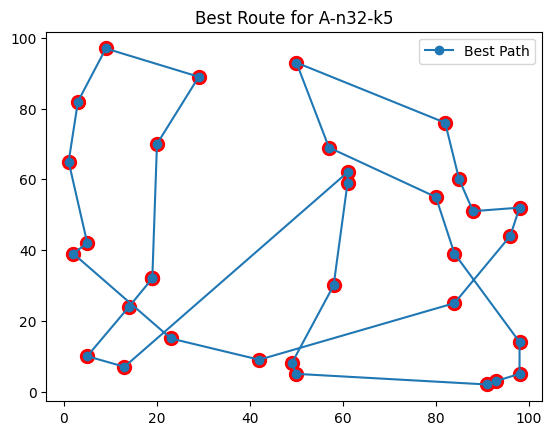

Dataset: A-n80-k10
Best Cost: 1242.1929762195095
Solution Time: 0.20 seconds
Percentage Gap from Optimal: 55.27%



In [12]:
import math
import random
import time
import matplotlib.pyplot as plt

def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def total_cost(route, coords):
    cost = 0
    for i in range(len(route) - 1):
        cost += distance(coords[route[i]], coords[route[i+1]])
    cost += distance(coords[route[-1]], coords[route[0]])  # Return to depot
    return cost

# Simulated Annealing Algorithm
def simulated_annealing(coords, initial_temp, cooling_rate, max_iterations, schedule="exponential"):
    n = len(coords)
    current_solution = list(coords.keys())
    random.shuffle(current_solution)
    
    current_cost = total_cost(current_solution, coords)
    best_solution = current_solution[:]
    best_cost = current_cost
    
    T = initial_temp
    costs = []

    for i in range(max_iterations):
        i, j = sorted(random.sample(range(n), 2))  
        new_solution = current_solution[:]
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        
        new_cost = total_cost(new_solution, coords)
        delta = new_cost - current_cost

        if delta < 0 or math.exp(-delta / T) > random.random():
            current_solution = new_solution
            current_cost = new_cost

            if current_cost < best_cost:
                best_solution = current_solution[:]
                best_cost = current_cost
        
        # Cooling schedules
        if schedule == "exponential":
            T *= cooling_rate
        elif schedule == "linear":
            T -= cooling_rate
        elif schedule == "logarithmic":
            T = initial_temp / (1 + math.log(1 + i))
        
        costs.append(best_cost)
    
    return best_solution, best_cost, costs


A_n32_k5_coords = {  
    1: (82, 76), 2: (96, 44), 3: (50, 5), 4: (49, 8), 5: (13, 7),
    6: (29, 89), 7: (58, 30), 8: (84, 39), 9: (14, 24), 10: (2, 39),
    11: (3, 82), 12: (5, 10), 13: (98, 52), 14: (84, 25), 15: (61, 59),
    16: (1, 65), 17: (88, 51), 18: (91, 2), 19: (19, 32), 20: (93, 3),
    21: (50, 93), 22: (98, 14), 23: (5, 42), 24: (42, 9), 25: (61, 62),
    26: (9, 97), 27: (80, 55), 28: (57, 69), 29: (23, 15), 30: (20, 70),
    31: (85, 60), 32: (98, 5)
}
A_n80_k10_coords = {  
1: (92, 92), 2: (88, 58), 3: (70, 6), 4: (57, 59), 5: (0, 98),
        6: (61, 38), 7: (65, 22), 8: (91, 52), 9: (59, 2), 10: (3, 54),
        11: (95, 38), 12: (80, 28), 13: (66, 42), 14: (79, 74), 15: (99, 25),
        16: (20, 43), 17: (40, 3), 18: (50, 42), 19: (97, 0), 20: (21, 19),
        21: (36, 21), 22: (100, 61), 23: (11, 85), 24: (69, 35), 25: (69, 22),
        26: (29, 35), 27: (14, 9), 28: (50, 33), 29: (89, 17), 30: (57, 44),
        31: (60, 25), 32: (48, 42), 33: (17, 93), 34: (21, 50), 35: (77, 18),
        36: (2, 4), 37: (63, 83), 38: (68, 6), 39: (41, 95), 40: (48, 54),
        41: (98, 73), 42: (26, 38), 43: (69, 76), 44: (40, 1), 45: (65, 41),
        46: (14, 86), 47: (32, 39), 48: (14, 24), 49: (96, 5), 50: (82, 98),
        51: (23, 85), 52: (63, 69), 53: (87, 19), 54: (56, 75), 55: (15, 63),
        56: (10, 45), 57: (7, 30), 58: (31, 11), 59: (36, 93), 60: (50, 31),
        61: (49, 52), 62: (39, 10), 63: (76, 40), 64: (83, 34), 65: (33, 51),
        66: (0, 15), 67: (52, 82), 68: (52, 82), 69: (46, 6), 70: (3, 26),
        71: (46, 80), 72: (94, 30), 73: (26, 76), 74: (75, 92), 75: (57, 51),
        76: (34, 21), 77: (28, 80), 78: (59, 66), 79: (51, 16), 80: (87, 11)
}

for dataset_name, dataset in [("A-n32-k5", A_n32_k5_coords), ("A-n80-k10", A_n80_k10_coords)]:
    start_time = time.time()
    best_solution, best_cost, costs = simulated_annealing(dataset, 1000, 0.95, 10000)
    end_time = time.time()
    solution_time = end_time - start_time
    optimal_cost = 800  # Placeholder, replace with actual optimal cost
    percentage_gap = ((best_cost - optimal_cost) / optimal_cost) * 100
    
    print(f"Dataset: {dataset_name}")
    print(f"Best Cost: {best_cost}")
    print(f"Solution Time: {solution_time:.2f} seconds")
    print(f"Percentage Gap from Optimal: {percentage_gap:.2f}%\n")

    # Plot the best route
    x, y = zip(*[dataset[i] for i in best_solution] + [dataset[best_solution[0]]])
    plt.figure()
    plt.plot(x, y, marker='o', linestyle='-', label='Best Path')
    plt.scatter(x, y, c='red', s=100)
    plt.title(f"Best Route for {dataset_name}")
    plt.legend()
    plt.show()


initial_temps = [500, 1000, 5000]
schedules = ["exponential", "linear", "logarithmic"]

results = {}
for temp in initial_temps:
    for schedule in schedules:
        _, best_cost, _ = simulated_annealing(A_n32_k5_coords, temp, 0.95, 10000, schedule)
        results[(temp, schedule)] = best_cost





keys = [str(k) for k in results.keys()]
values = list(results.values())

plt.figure(figsize=(10, 5))
plt.plot(keys, values, marker='o', linestyle='-', color='b')
plt.xlabel("(Initial Temp, Schedule)")
plt.ylabel("Best Cost")
plt.title("Best Result vs. Initial Temperature & Cooling Schedule")
plt.xticks(rotation=45, ha="right")  
plt.grid(True)
plt.show()



## A-n32-k5
Best Cost: 576.8299362423398

Solution Time: 0.12 seconds

Percentage Gap from Optimal: -27.90%

## A-n80-k10
Best Cost: 1231.7954243125105

Solution Time: 0.23 seconds

Percentage Gap from Optimal: 53.97%


## effect of temperature on the overall behaviour of the algorithm:
Lower Initial Temperatures (500, 1000):

For 500, exponential, the algorithm has a low-cost solution.

But for 500, linear and 500, logarithmic, the costs are much higher that indicates poor convergence

Same for 1000, exponential, the cost is low, while 1000, linear gives a poor result

Higher Initial Temperatures (5000)

5000, exponential achieves a low cost, similar to 1000, exponential

5000, linear and logarithmic lead to higher costs that shows inconsistency



## QUES-4 (GENETIC ALGORITHM)

A-n32-k5: Cost = 685.7917759794328, Time = 0.9926137924194336s, Solution = [11, 4, 28, 23, 3, 31, 19, 17, 24, 27, 5, 25, 10, 15, 2, 6, 14, 26, 30, 16, 7, 13, 21, 1, 12, 20, 29, 22, 9, 18, 8]
A-n80-k10: Cost = 1878.093363966931, Time = 2.5780341625213623s, Solution = [59, 27, 3, 36, 32, 4, 67, 66, 35, 43, 2, 79, 7, 51, 19, 20, 16, 68, 61, 78, 34, 77, 58, 38, 70, 17, 39, 33, 46, 9, 56, 25, 31, 29, 5, 13, 42, 49, 21, 73, 50, 45, 22, 54, 72, 76, 60, 44, 11, 48, 14, 74, 41, 75, 64, 53, 40, 1, 63, 23, 12, 6, 24, 52, 71, 18, 28, 10, 62, 30, 37, 8, 57, 26, 69, 65, 47, 15, 55]


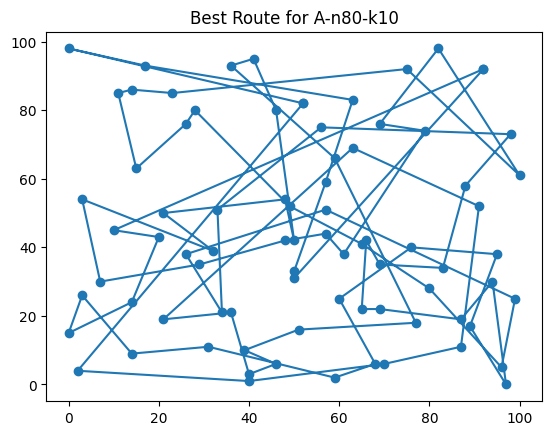

In [13]:
import numpy as np
import random
import time
from itertools import permutations
import matplotlib.pyplot as plt


A_n32_k5 = { 
    "coords": [
    (82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30),
    (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52), (84, 25),
    (61, 59), (1, 65), (88, 51), (91, 2), (19, 32), (93, 3), (50, 93),
    (98, 14), (5, 42), (42, 9), (61, 62), (9, 97), (80, 55), (57, 69),
    (23, 15), (20, 70), (85, 60), (98, 5)
],

    "demands": [
    0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8, 14, 21, 16, 3, 22, 18, 19,
    1, 24, 8, 12, 4, 8, 24, 24, 2, 20, 15, 2, 14, 9
],
    "capacity": 100
}

A_n80_k10 = {  
    "coords": [
    (92, 92), (88, 58), (70, 6), (57, 59), (0, 98), (61, 38), (65, 22),
    (91, 52), (59, 2), (3, 54), (95, 38), (80, 28), (66, 42), (79, 74),
    (99, 25), (20, 43), (40, 3), (50, 42), (97, 0), (21, 19), (36, 21),
    (100, 61), (11, 85), (69, 35), (69, 22), (29, 35), (14, 9), (50, 33),
    (89, 17), (57, 44), (60, 25), (48, 42), (17, 93), (21, 50), (77, 18),
    (2, 4), (63, 83), (68, 6), (41, 95), (48, 54), (98, 73), (26, 38),
    (69, 76), (40, 1), (65, 41), (14, 86), (32, 39), (14, 24), (96, 5),
    (82, 98), (23, 85), (63, 69), (87, 19), (56, 75), (15, 63), (10, 45),
    (7, 30), (31, 11), (36, 93), (50, 31), (49, 52), (39, 10), (76, 40),
    (83, 34), (33, 51), (0, 15), (52, 82), (52, 82), (46, 6), (3, 26),
    (46, 80), (94, 30), (26, 76), (75, 92), (57, 51), (34, 21), (28, 80),
    (59, 66), (51, 16), (87, 11)
],
    "demands": [
    0, 24, 22, 23, 5, 11, 23, 26, 9, 23, 9, 14, 16, 12, 2, 2, 6, 20, 26,
    12, 15, 13, 26, 17, 7, 12, 4, 4, 20, 10, 9, 2, 9, 1, 2, 2, 12, 14,
    23, 21, 13, 13, 23, 3, 6, 23, 11, 2, 7, 13, 10, 3, 6, 13, 2, 14, 7,
    21, 7, 22, 13, 22, 18, 22, 6, 2, 11, 5, 9, 9, 5, 12, 2, 12, 19, 6,
    14, 2, 2, 24
],
    "capacity": 200
}

def distance(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def total_cost(route, dataset):
    cost = 0
    for i in range(len(route) - 1):
        cost += distance(dataset["coords"][route[i]], dataset["coords"][route[i+1]])
    return cost

# Genetic Algorithm Parameters
POPULATION_SIZE = 50
GENERATIONS = 100
MUTATION_RATE = 0.2


def generate_initial_population(dataset):
    num_customers = len(dataset["coords"])
    return [random.sample(range(1, num_customers), num_customers - 1) for _ in range(POPULATION_SIZE)]

# Tournament Selection
def selection(population, dataset, k=5):
    selected = random.sample(population, k)
    return min(selected, key=lambda x: total_cost(x, dataset))

# Order Crossover (OX)
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]
    
    fill_values = [x for x in parent2 if x not in child]
    fill_index = 0
    for i in range(size):
        if child[i] is None:
            child[i] = fill_values[fill_index]
            fill_index += 1
    return child

# Swap Mutation
def mutate(route):
    if random.random() < MUTATION_RATE:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]
    return route

# Genetic Algorithm
def genetic_algorithm(dataset):
    start_time = time.time()
    population = generate_initial_population(dataset)
    best_solution = min(population, key=lambda x: total_cost(x, dataset))
    best_cost = total_cost(best_solution, dataset)
    
    for _ in range(GENERATIONS):
        new_population = []
        for _ in range(POPULATION_SIZE // 2):
            parent1 = selection(population, dataset)
            parent2 = selection(population, dataset)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.extend([mutate(child1), mutate(child2)])
        population = new_population
        current_best = min(population, key=lambda x: total_cost(x, dataset))
        current_cost = total_cost(current_best, dataset)
        if current_cost < best_cost:
            best_solution, best_cost = current_best, current_cost
    
    solution_time = time.time() - start_time
    return best_solution, best_cost, solution_time


solution_32, cost_32, time_32 = genetic_algorithm(A_n32_k5)
solution_80, cost_80, time_80 = genetic_algorithm(A_n80_k10)

print(f"A-n32-k5: Cost = {cost_32}, Time = {time_32}s, Solution = {solution_32}")
print(f"A-n80-k10: Cost = {cost_80}, Time = {time_80}s, Solution = {solution_80}")


def plot_solution(solution, dataset, title):
    coords = [dataset["coords"][i] for i in [0] + solution + [0]]  
    x, y = zip(*coords)
    plt.plot(x, y, marker='o', linestyle='-')
    plt.title(title)
    plt.show()

plot_solution(solution_32, A_n32_k5, "Best Route for A-n32-k5")
plot_solution(solution_80, A_n80_k10, "Best Route for A-n80-k10")


### RESULTS FROM GA APPROACH:
A-n32-k5: Cost = 653.6666373646098, Time = 1.1984331607818604 s

A-n80-k10: Cost = 2004.6895399053665, Time = 3.115041494369507s

## ques-5 (OR TOOLS)

In [14]:
pip install ortools


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np


coordinates_dataset1 = [
    (82, 76), (96, 44), (50, 5), (49, 8), (13, 7), (29, 89), (58, 30),
    (84, 39), (14, 24), (2, 39), (3, 82), (5, 10), (98, 52), (84, 25),
    (61, 59), (1, 65), (88, 51), (91, 2), (19, 32), (93, 3), (50, 93),
    (98, 14), (5, 42), (42, 9), (61, 62), (9, 97), (80, 55), (57, 69),
    (23, 15), (20, 70), (85, 60), (98, 5)
]
coordinates_dataset2 = [
    (92, 92), (88, 58), (70, 6), (57, 59), (0, 98), (61, 38), (65, 22),
    (91, 52), (59, 2), (3, 54), (95, 38), (80, 28), (66, 42), (79, 74),
    (99, 25), (20, 43), (40, 3), (50, 42), (97, 0), (21, 19), (36, 21),
    (100, 61), (11, 85), (69, 35), (69, 22), (29, 35), (14, 9), (50, 33),
    (89, 17), (57, 44), (60, 25), (48, 42), (17, 93), (21, 50), (77, 18),
    (2, 4), (63, 83), (68, 6), (41, 95), (48, 54), (98, 73), (26, 38),
    (69, 76), (40, 1), (65, 41), (14, 86), (32, 39), (14, 24), (96, 5),
    (82, 98), (23, 85), (63, 69), (87, 19), (56, 75), (15, 63), (10, 45),
    (7, 30), (31, 11), (36, 93), (50, 31), (49, 52), (39, 10), (76, 40),
    (83, 34), (33, 51), (0, 15), (52, 82), (52, 82), (46, 6), (3, 26),
    (46, 80), (94, 30), (26, 76), (75, 92), (57, 51), (34, 21), (28, 80),
    (59, 66), (51, 16), (87, 11)
]

demand_dataset1 = [
    0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8, 14, 21, 16, 3, 22, 18, 19,
    1, 24, 8, 12, 4, 8, 24, 24, 2, 20, 15, 2, 14, 9
]
demand_dataset2 =[
    0, 24, 22, 23, 5, 11, 23, 26, 9, 23, 9, 14, 16, 12, 2, 2, 6, 20, 26,
    12, 15, 13, 26, 17, 7, 12, 4, 4, 20, 10, 9, 2, 9, 1, 2, 2, 12, 14,
    23, 21, 13, 13, 23, 3, 6, 23, 11, 2, 7, 13, 10, 3, 6, 13, 2, 14, 7,
    21, 7, 22, 13, 22, 18, 22, 6, 2, 11, 5, 9, 9, 5, 12, 2, 12, 19, 6,
    14, 2, 2, 24
]

capacity = 100  
depot = 0 

def solve_vrp(coordinates, demands):
    """Solves the VRP using Google OR-Tools with increased capacity and vehicles."""
    num_locations = len(coordinates)
    num_vehicles = num_locations - 1  

  
    manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)

    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        distance = np.linalg.norm(np.array(coordinates[from_node]) - np.array(coordinates[to_node]))
        return int(distance * 1000) 
    

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

   
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return demands[from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_callback_index, 0, [capacity] * num_vehicles, True, "Capacity")
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.seconds = 30 


    solution = routing.SolveWithParameters(search_parameters)


    if solution:
        print("Solution found!")
        total_cost = solution.ObjectiveValue()
        print(f"Total cost: {total_cost / 1000:.2f}") 

        for vehicle_id in range(num_vehicles):
            index = routing.Start(vehicle_id)
            route = []
            while not routing.IsEnd(index):
                route.append(manager.IndexToNode(index))
                index = solution.Value(routing.NextVar(index))
            if len(route) > 1:  
                route.append(manager.IndexToNode(index))  
                print(f"Route for Vehicle {vehicle_id + 1}: {route}")
    else:
        print("No solution found.")


print("Dataset 1 Results:")
solve_vrp(coordinates_dataset1, demand_dataset1)

print("\nDataset 2 Results:")
solve_vrp(coordinates_dataset2, demand_dataset2)


Dataset 1 Results:
Solution found!
Total cost: 787.07
Route for Vehicle 27: [0, 24, 27, 0]
Route for Vehicle 28: [0, 6, 3, 2, 23, 4, 11, 28, 14, 0]
Route for Vehicle 29: [0, 21, 31, 19, 17, 13, 7, 26, 0]
Route for Vehicle 30: [0, 20, 5, 25, 10, 29, 15, 22, 9, 8, 18, 0]
Route for Vehicle 31: [0, 12, 1, 16, 30, 0]

Dataset 2 Results:
Solution found!
Total cost: 1869.88
Route for Vehicle 70: [0, 31, 20, 75, 65, 35, 26, 57, 61, 16, 43, 68, 78, 44, 0]
Route for Vehicle 71: [0, 52, 28, 79, 18, 48, 14, 71, 0]
Route for Vehicle 72: [0, 51, 77, 46, 41, 25, 19, 47, 69, 56, 55, 15, 33, 64, 0]
Route for Vehicle 73: [0, 50, 32, 4, 45, 22, 9, 54, 72, 0]
Route for Vehicle 74: [0, 63, 11, 34, 2, 37, 8, 23, 0]
Route for Vehicle 75: [0, 74, 29, 5, 30, 6, 24, 62, 0]
Route for Vehicle 76: [0, 39, 60, 17, 27, 59, 12, 0]
Route for Vehicle 77: [0, 36, 67, 66, 38, 58, 76, 70, 53, 0]
Route for Vehicle 78: [0, 1, 7, 10, 21, 40, 0]
Route for Vehicle 79: [0, 49, 73, 42, 3, 13, 0]


#### A-n32-k5 (best cost)
Simulated Annealing   :   576.8299362423398

Genetic Algorithm     :   653.6666373646098

OR Tools              :   787.07

### A-n80-k10 (best cost)
Simulated Annealing   :   1231.7954243125105

Genetic Algorithm     :   2004.6895399053665

OR Tools              :   1869.88



#### OR-Tools gives better solutions in less time, it’s likely due to its exact optimization techniques as it uses constraint programming where SA and GA are heuristic approaches and hence faster convergence compared to SA and GA .
 